#### Load the libraries 

In [56]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


#### Library to ignore warning 

In [57]:
import warnings
warnings.filterwarnings('ignore')

## Data 

In [58]:
!pip install sklearn

#### Reading Train data

In [59]:
Train = pd.read_csv("Traindata_with_Target.csv", na_values=[" ",".","NA","?","-",""])
Train_Claim = pd.read_csv("Train_Claim.csv", na_values=[" ","MISSEDDATA","NA","?","-5","MISSINGVALUE",""])
Train_Demographics = pd.read_csv("Train_Demographics.csv",na_values=[" ",".","NA","-",""] )
Train_Policy = pd.read_csv("Train_Policy.csv",na_values=[" ",".","NA","MISSINGVAL","-1",""])
Train_Vehicle = pd.read_csv("Train_Vehicle.csv",na_values=[" ",".","NA","???","-1",""])

#### Reading Test data

In [60]:
Test = pd.read_csv("output.csv", na_values=[" ",".","NA","?","-",""])
Test_Claim = pd.read_csv("Test_Claim.csv", na_values=[" ","MISSEDDATA","NA","?","-5","MISSINGVALUE",""])
Test_Demographics = pd.read_csv("Test_Demographics.csv",na_values=[" ",".","NA","-",""] )
Test_Policy = pd.read_csv("Test_Policy.csv",na_values=[" ",".","NA","MISSINGVAL","-1",""])
Test_Vehicle = pd.read_csv("Test_Vehicle.csv",na_values=[" ",".","NA","???","-1",""])

Conversion of Catrgorical column to object type 

In [61]:
Train_Demographics['InsuredZipCode']=Train_Demographics['InsuredZipCode'].astype('object')
Test_Demographics['InsuredZipCode']=Test_Demographics['InsuredZipCode'].astype('object')
Train_Policy['InsurancePolicyNumber']=Train_Policy['InsurancePolicyNumber'].astype('object')
Test_Policy['InsurancePolicyNumber']=Test_Policy['InsurancePolicyNumber'].astype('object')
Train_Claim['NumberOfVehicles']=Train_Claim['NumberOfVehicles'].astype('object')
Train_Claim['BodilyInjuries']=Train_Claim['BodilyInjuries'].astype('object')
Train_Claim['Witnesses']=Train_Claim['Witnesses'].astype('object')
Test_Claim['NumberOfVehicles']=Test_Claim['NumberOfVehicles'].astype('object')
Test_Claim['BodilyInjuries']=Test_Claim['BodilyInjuries'].astype('object')
Test_Claim['Witnesses']=Test_Claim['Witnesses'].astype('object')

since after inspection vehicle attribute and vehicle attribute details have soem common relation - applying pivot

In [62]:
Train_Vehicle.pivot(index='CustomerID',columns='VehicleAttribute',values='VehicleAttributeDetails').head(5)

VehicleAttribute,VehicleID,VehicleMake,VehicleModel,VehicleYOM
CustomerID,,,,
Cust10000,Vehicle26917,Audi,A5,2008
Cust10001,Vehicle15893,Audi,A5,2006
Cust10002,Vehicle5152,Volkswagen,Jetta,1999
Cust10003,Vehicle37363,Volkswagen,Jetta,2003
Cust10004,Vehicle28633,Toyota,CRV,2010


In [63]:
Test_Vehicle.pivot(index='CustomerID',columns='VehicleAttribute',values='VehicleAttributeDetails').head(5)

VehicleAttribute,VehicleID,VehicleMake,VehicleModel,VehicleYOM
CustomerID,,,,
Cust10008,Vehicle34362,Volkswagen,Passat,1995
Cust10010,Vehicle17046,Nissan,Ultima,2006
Cust10015,Vehicle11038,Suburu,Impreza,2010
Cust10020,Vehicle37114,Accura,TL,2009
Cust1003,Vehicle16771,Dodge,RAM,2007


In [64]:
Train_Vehicle=Train_Vehicle.pivot(index='CustomerID',columns='VehicleAttribute',values='VehicleAttributeDetails').reset_index()
Test_Vehicle=Test_Vehicle.pivot(index='CustomerID',columns='VehicleAttribute',values='VehicleAttributeDetails').reset_index()

Changing Y and N to 1 and 0's 

In [65]:
Train['ReportedFraud']=Train['ReportedFraud'].apply(lambda x: 1 if x=='Y' else 0)

### Merging Train dataset

In [66]:
Merged_Train1 = pd.merge(Train,Train_Claim, how = "inner", on='CustomerID')
Merged_Train2 = pd.merge(Merged_Train1,Train_Demographics, how ="inner", on='CustomerID')
Merged_Train3 = pd.merge(Merged_Train2,Train_Policy, how ="inner", on='CustomerID')
Merged_Train4 = pd.merge(Merged_Train3,Train_Vehicle, how ="inner", on='CustomerID')
data=Merged_Train4

### Merging Test dataset

In [67]:
Merged_Test1 = pd.merge(Test,Test_Claim, how = "inner", on='CustomerID')
Merged_Test2 = pd.merge(Merged_Test1,Test_Demographics, how ="inner", on='CustomerID')
Merged_Test3 = pd.merge(Merged_Test2,Test_Policy, how ="inner", on='CustomerID')
Merged_Test4 = pd.merge(Merged_Test3,Test_Vehicle, how ="inner", on='CustomerID')
data_test=Merged_Test4

### Understanding the Data

In [68]:
data.shape

(28836, 42)

In [69]:
data_test.shape

(8912, 42)

### Column names 

In [70]:
data.columns

Index(['CustomerID', 'ReportedFraud', 'DateOfIncident', 'TypeOfIncident',
       'TypeOfCollission', 'SeverityOfIncident', 'AuthoritiesContacted',
       'IncidentState', 'IncidentCity', 'IncidentAddress', 'IncidentTime',
       'NumberOfVehicles', 'PropertyDamage', 'BodilyInjuries', 'Witnesses',
       'PoliceReport', 'AmountOfTotalClaim', 'AmountOfInjuryClaim',
       'AmountOfPropertyClaim', 'AmountOfVehicleDamage', 'InsuredAge',
       'InsuredZipCode', 'InsuredGender', 'InsuredEducationLevel',
       'InsuredOccupation', 'InsuredHobbies', 'CapitalGains', 'CapitalLoss',
       'Country', 'InsurancePolicyNumber', 'CustomerLoyaltyPeriod',
       'DateOfPolicyCoverage', 'InsurancePolicyState',
       'Policy_CombinedSingleLimit', 'Policy_Deductible',
       'PolicyAnnualPremium', 'UmbrellaLimit', 'InsuredRelationship',
       'VehicleID', 'VehicleMake', 'VehicleModel', 'VehicleYOM'],
      dtype='object')

In [71]:
data_test.columns

Index(['CustomerID', 'ReportedFraud', 'DateOfIncident', 'TypeOfIncident',
       'TypeOfCollission', 'SeverityOfIncident', 'AuthoritiesContacted',
       'IncidentState', 'IncidentCity', 'IncidentAddress', 'IncidentTime',
       'NumberOfVehicles', 'PropertyDamage', 'BodilyInjuries', 'Witnesses',
       'PoliceReport', 'AmountOfTotalClaim', 'AmountOfInjuryClaim',
       'AmountOfPropertyClaim', 'AmountOfVehicleDamage', 'InsuredAge',
       'InsuredZipCode', 'InsuredGender', 'InsuredEducationLevel',
       'InsuredOccupation', 'InsuredHobbies', 'CapitalGains', 'CapitalLoss',
       'Country', 'InsurancePolicyNumber', 'CustomerLoyaltyPeriod',
       'DateOfPolicyCoverage', 'InsurancePolicyState',
       'Policy_CombinedSingleLimit', 'Policy_Deductible',
       'PolicyAnnualPremium', 'UmbrellaLimit', 'InsuredRelationship',
       'VehicleID', 'VehicleMake', 'VehicleModel', 'VehicleYOM'],
      dtype='object')

In [72]:
data.head()

,CustomerID,ReportedFraud,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,...,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM
0,Cust20065,0,2015-01-09,Multi-vehicle Collision,Rear Collision,Total Loss,Other,State9,City4,Location 1404,...,State2,250/500,2000,1142.87,0,own-child,Vehicle30662,Mercedes,E400,2005
1,Cust37589,0,2015-02-20,Single Vehicle Collision,Side Collision,Minor Damage,Ambulance,State4,City3,Location 1675,...,State2,100/300,1000,1274.38,2857344,own-child,Vehicle17183,Toyota,Highlander,2010
2,Cust24312,0,2015-01-14,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,State5,City2,Location 1546,...,State1,500/1000,745,1269.93,0,other-relative,Vehicle33982,Volkswagen,Passat,2002
3,Cust5493,1,2015-01-07,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,State7,City4,Location 1413,...,State2,100/300,986,1218.60,0,other-relative,Vehicle12299,Toyota,Highlander,2011
4,Cust7704,1,2015-02-26,Multi-vehicle Collision,Side Collision,Major Damage,Other,State4,City6,Location 1367,...,State3,250/500,576,1431.02,4235779,unmarried,Vehicle30447,Ford,Wrangler,2010


In [73]:
data_test.head()

,CustomerID,ReportedFraud,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,...,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM
0,Cust10008,0,2015-02-05,Multi-vehicle Collision,Front Collision,Minor Damage,Ambulance,State5,City2,Location 1354,...,State2,500/1000,2000,1006.00,0,own-child,Vehicle34362,Volkswagen,Passat,1995
1,Cust10010,0,2015-01-13,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State9,City5,Location 1383,...,State3,100/300,500,1279.17,0,unmarried,Vehicle17046,Nissan,Ultima,2006
2,Cust10015,0,2015-01-05,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,State5,City2,Location 2030,...,State2,250/500,1000,1454.67,1235986,other-relative,Vehicle11038,Suburu,Impreza,2010
3,Cust10020,0,2015-01-03,Vehicle Theft,NaN,Trivial Damage,None,State7,City5,Location 1449,...,State3,500/500,2000,1287.76,5873212,wife,Vehicle37114,Accura,TL,2009
4,Cust1003,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,State5,City2,Location 1916,...,State3,100/300,2000,1413.14,5000000,own-child,Vehicle16771,Dodge,RAM,2007


Checking for insignificant columns 

In [74]:
def insignificantCols(dataset):
    insignificantCols=[]
    size=dataset.shape[0]
    for i in dataset.columns:
        x=dataset[i].nunique()
        if (x==size)|(x==1):
            insignificantCols.append(i)
    return insignificantCols

In [75]:
insigCol=insignificantCols(data)
insigCol

['CustomerID', 'Country', 'InsurancePolicyNumber', 'VehicleID']

#### Dropping insignificant columns 

In [76]:
data.drop(['CustomerID', 'Country', 'InsurancePolicyNumber', 'VehicleID'],axis=1,inplace=True)

In [77]:
data_test.drop(['CustomerID', 'Country', 'InsurancePolicyNumber', 'VehicleID'],axis=1,inplace=True)

#### Data Type

In [78]:
type(data)

pandas.core.frame.DataFrame

In [79]:
type(data_test)

pandas.core.frame.DataFrame

#### Display data type of each variable

In [80]:
data.dtypes

ReportedFraud                   int64
DateOfIncident                 object
TypeOfIncident                 object
TypeOfCollission               object
SeverityOfIncident             object
AuthoritiesContacted           object
IncidentState                  object
IncidentCity                   object
IncidentAddress                object
IncidentTime                  float64
NumberOfVehicles               object
PropertyDamage                 object
BodilyInjuries                 object
Witnesses                      object
PoliceReport                   object
AmountOfTotalClaim            float64
AmountOfInjuryClaim             int64
AmountOfPropertyClaim           int64
AmountOfVehicleDamage           int64
InsuredAge                      int64
InsuredZipCode                 object
InsuredGender                  object
InsuredEducationLevel          object
InsuredOccupation              object
InsuredHobbies                 object
CapitalGains                    int64
CapitalLoss 

#### Summary of data

In [81]:
data.describe(include='all')

,ReportedFraud,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,...,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleMake,VehicleModel,VehicleYOM
count,28836.000000,28836,28836,23674,28836,28836,28836,28836,28836,28805.000000,...,28836,28836,28836,28836.000000,28695.000000,2.883600e+04,28836,28786,28836,28836
unique,NaN,72,4,3,4,5,7,7,1000,NaN,...,6779,3,9,NaN,NaN,NaN,6,14,39,21
top,NaN,2015-01-10,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,State5,City2,Location 1341,NaN,...,11/11/1998,State3,250/500,NaN,NaN,NaN,own-child,Saab,RAM,2007
freq,NaN,661,11966,8561,10400,8324,7886,4486,73,NaN,...,38,10146,8260,NaN,NaN,NaN,5242,2415,1344,1730
mean,0.269975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.764069,...,NaN,NaN,NaN,1114.282529,1261.702646,9.836680e+05,NaN,NaN,NaN,NaN
std,0.443954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.148869,...,NaN,NaN,NaN,546.632816,205.385158,1.969282e+06,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,500.000000,436.280000,-1.000000e+06,NaN,NaN,NaN,NaN
25%,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,...,NaN,NaN,NaN,622.000000,1124.425000,0.000000e+00,NaN,NaN,NaN,NaN
50%,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,...,NaN,NaN,NaN,1000.000000,1266.440000,0.000000e+00,NaN,NaN,NaN,NaN
75%,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.000000,...,NaN,NaN,NaN,1627.000000,1397.200000,4.859610e+05,NaN,NaN,NaN,NaN


In [82]:
data_test.describe(include='all')

,ReportedFraud,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,...,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleMake,VehicleModel,VehicleYOM
count,8912.000000,8912,8912,7149,8912,8912,8912,8912,8912,8905.000000,...,8912,8912,8912,8912.000000,8865.000000,8.912000e+03,8912,8904,8912,8912
unique,NaN,67,4,3,4,5,7,7,996,NaN,...,4533,3,9,NaN,NaN,NaN,6,14,38,21
top,NaN,2015-02-17,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,State5,City2,Location 1341,NaN,...,1992-04-14,State3,100/300,NaN,NaN,NaN,own-child,Suburu,Wrangler,2010
freq,NaN,211,3594,2602,3378,2623,2489,1405,29,NaN,...,15,3132,2561,NaN,NaN,NaN,1643,743,507,544
mean,0.147442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.785963,...,NaN,NaN,NaN,1123.580790,1260.235059,9.318594e+05,NaN,NaN,NaN,NaN
std,0.354566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.157104,...,NaN,NaN,NaN,553.139684,205.534081,1.919603e+06,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,500.000000,433.330000,-8.836920e+05,NaN,NaN,NaN,NaN
25%,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,...,NaN,NaN,NaN,622.000000,1119.460000,0.000000e+00,NaN,NaN,NaN,NaN
50%,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,...,NaN,NaN,NaN,1000.000000,1265.840000,0.000000e+00,NaN,NaN,NaN,NaN
75%,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.000000,...,NaN,NaN,NaN,1691.250000,1399.240000,2.836810e+05,NaN,NaN,NaN,NaN


#### Dropping  columns

In [83]:
data.drop(['InsuredGender','InsuredZipCode','IncidentState','InsuredHobbies','Policy_CombinedSingleLimit','UmbrellaLimit','InsuredRelationship','TypeOfCollission','AmountOfInjuryClaim','AmountOfPropertyClaim','AmountOfVehicleDamage','IncidentAddress'],axis=1,inplace=True)

In [84]:
data_test.drop(['InsuredGender','InsuredZipCode','IncidentState','InsuredHobbies','Policy_CombinedSingleLimit','UmbrellaLimit','InsuredRelationship','TypeOfCollission','AmountOfInjuryClaim','AmountOfPropertyClaim','AmountOfVehicleDamage','IncidentAddress'],axis=1,inplace=True)

In [85]:
data.shape

(28836, 26)

In [86]:
data_test.shape

(8912, 26)

#### Missing Data Analysis

In [87]:
data.isnull().sum()

ReportedFraud                0
DateOfIncident               0
TypeOfIncident               0
SeverityOfIncident           0
AuthoritiesContacted         0
IncidentCity                 0
IncidentTime                31
NumberOfVehicles             0
PropertyDamage           10459
BodilyInjuries               0
Witnesses                   46
PoliceReport              9805
AmountOfTotalClaim          50
InsuredAge                   0
InsuredEducationLevel        0
InsuredOccupation            0
CapitalGains                 0
CapitalLoss                  0
CustomerLoyaltyPeriod        0
DateOfPolicyCoverage         0
InsurancePolicyState         0
Policy_Deductible            0
PolicyAnnualPremium        141
VehicleMake                 50
VehicleModel                 0
VehicleYOM                   0
dtype: int64

In [88]:
data_test.isnull().sum()

ReportedFraud               0
DateOfIncident              0
TypeOfIncident              0
SeverityOfIncident          0
AuthoritiesContacted        0
IncidentCity                0
IncidentTime                7
NumberOfVehicles            0
PropertyDamage           3199
BodilyInjuries              0
Witnesses                  12
PoliceReport             3014
AmountOfTotalClaim          8
InsuredAge                  0
InsuredEducationLevel       0
InsuredOccupation           0
CapitalGains                0
CapitalLoss                 0
CustomerLoyaltyPeriod       0
DateOfPolicyCoverage        0
InsurancePolicyState        0
Policy_Deductible           0
PolicyAnnualPremium        47
VehicleMake                 8
VehicleModel                0
VehicleYOM                  0
dtype: int64

In [89]:
print (data.shape)

(28836, 26)


In [90]:
print(data_test.shape)

(8912, 26)


# Feature engineering  

### Extracting month and day

Extracting month and day from Date of Incident and policy coverage 

In [91]:
data['Incident_month'] = pd.DatetimeIndex(data['DateOfIncident']).month
data['Incident_day'] = pd.DatetimeIndex(data['DateOfIncident']).day
data['Policy_month'] = pd.DatetimeIndex(data['DateOfPolicyCoverage']).month  ## Month of Date policy coverage

Repeating for test data

In [92]:
data_test['Incident_month'] = pd.DatetimeIndex(data_test['DateOfIncident']).month
data_test['Incident_day'] = pd.DatetimeIndex(data_test['DateOfIncident']).day
data_test['Policy_month'] = pd.DatetimeIndex(data_test['DateOfPolicyCoverage']).month  ## Month of Date policy coverage

### Combining gain and loss columns to get one column representing loss or gain

Train

In [93]:
data['Total_gain_loss'] = data['CapitalGains']+data['CapitalLoss']
data['nor_Total_gain_loss'] = (data['Total_gain_loss'] - data['Total_gain_loss'].min()) / (data['Total_gain_loss'].max() - data['Total_gain_loss'].min())

Test

In [94]:
data_test['Total_gain_loss'] = data_test['CapitalGains']+data_test['CapitalLoss']
data_test['nor_Total_gain_loss'] = (data_test['Total_gain_loss'] - data_test['Total_gain_loss'].min()) / (data_test['Total_gain_loss'].max() - data_test['Total_gain_loss'].min())

Normalization of Amount of total claim - The other amount columns are dropped as all of them added together forms Amount of Claim

Train

In [95]:
data['nor_Total_amount'] = (data['AmountOfTotalClaim'] - data['AmountOfTotalClaim'].min()) / (data['AmountOfTotalClaim'].max() - data['AmountOfTotalClaim'].min())

Test

In [96]:
data_test['nor_Total_amount'] = (data_test['AmountOfTotalClaim'] - data_test['AmountOfTotalClaim'].min()) / (data_test['AmountOfTotalClaim'].max() - data_test['AmountOfTotalClaim'].min())

Dropping columns which are feature engineered

Train

In [97]:
data.drop(["DateOfPolicyCoverage"], axis = 1, inplace = True)
data.drop(["DateOfIncident"], axis = 1, inplace = True)
data.drop(["CapitalGains"], axis = 1, inplace = True)
data.drop(["CapitalLoss"], axis = 1, inplace = True)
data.drop(["Total_gain_loss"], axis = 1, inplace = True)
data.drop(['AmountOfTotalClaim'], axis = 1, inplace = True)


Test

In [98]:
data_test.drop(["DateOfPolicyCoverage"], axis = 1, inplace = True)
data_test.drop(["DateOfIncident"], axis = 1, inplace = True)
data_test.drop(["CapitalGains"], axis = 1, inplace = True)
data_test.drop(["CapitalLoss"], axis = 1, inplace = True)
data_test.drop(["Total_gain_loss"], axis = 1, inplace = True)
data_test.drop(['AmountOfTotalClaim'], axis = 1, inplace = True)

Conversion into dataframe

In [99]:
df_data=pd.DataFrame(data)

In [100]:
df_data_test=pd.DataFrame(data_test)

Checking for shape

In [101]:
df_data.shape

(28836, 26)

In [102]:
df_data_test.shape

(8912, 26)

# DATA IMPUTATION 

Creating categorical and numerical dataframe and imputing numerical with mean and categorical with mode and combining both

Categorical

In [103]:
data_Cat =df_data[[ 'AuthoritiesContacted','InsuredEducationLevel','InsuredOccupation','InsurancePolicyState','TypeOfIncident','SeverityOfIncident','IncidentCity','Incident_day','NumberOfVehicles','PropertyDamage','BodilyInjuries','Witnesses','PoliceReport','Incident_month','Policy_month','ReportedFraud','VehicleMake','VehicleModel']]
data_test_Cat =df_data_test[[ 'AuthoritiesContacted','InsuredEducationLevel','InsuredOccupation','InsurancePolicyState','TypeOfIncident','SeverityOfIncident','IncidentCity','Incident_day','NumberOfVehicles','PropertyDamage','BodilyInjuries','Witnesses','PoliceReport','Incident_month','Policy_month','VehicleMake','VehicleModel']]

Numerical

In [104]:
data_Num = df_data[['InsuredAge','nor_Total_gain_loss','CustomerLoyaltyPeriod','IncidentTime','nor_Total_amount','Policy_Deductible','PolicyAnnualPremium','VehicleYOM']]
data_test_Num = df_data_test[['InsuredAge','nor_Total_gain_loss','CustomerLoyaltyPeriod','IncidentTime','nor_Total_amount','Policy_Deductible','PolicyAnnualPremium','VehicleYOM']]

Imputing  - TRAIN DATA  and combining

In [105]:
data_Cat = data_Cat.fillna(data_Cat.mode().iloc[0])
data_Num = data_Num.fillna(data_Num.mean())
data_comb = pd.concat([data_Cat, data_Num], axis = 1)

Imputing -TEST DATA and combining

In [106]:
data_test_Cat = data_test_Cat.fillna(data_test_Cat.mode().iloc[0])
data_test_Num = data_test_Num.fillna(data_test_Num.mean())
data_test_comb = pd.concat([data_test_Cat, data_test_Num], axis = 1)

In [107]:
df_data_comb=pd.DataFrame(data_comb)
df_data_test_comb=pd.DataFrame(data_test_comb)

Removing Vehicle Mode because of level mismatch 

In [108]:
df_data_comb.drop(["VehicleModel"], axis = 1, inplace = True)
df_data_test_comb.drop(["VehicleModel"], axis = 1, inplace = True)

# SCALING DATA

In [109]:
cat_cols1=['InsuredEducationLevel','InsuredOccupation','InsurancePolicyState','TypeOfIncident','SeverityOfIncident','IncidentCity','PropertyDamage','Witnesses','PoliceReport','VehicleMake']
num_cols1=['NumberOfVehicles','BodilyInjuries','Incident_month','Policy_month','InsuredAge','nor_Total_gain_loss','CustomerLoyaltyPeriod','IncidentTime','nor_Total_amount','Policy_Deductible','PolicyAnnualPremium','VehicleYOM']


In [110]:
df_data_comb = pd.get_dummies(df_data_comb, columns=cat_cols1, drop_first=True)

In [111]:
scaler = StandardScaler()

scaler.fit(df_data_comb.loc[:,num_cols1])

df_data_comb.loc[:,num_cols1] = scaler.transform(df_data_comb.loc[:,num_cols1])

In [112]:
df_data_comb.shape

(28836, 66)

# Test data Scaling

In [113]:
df_data_test_comb = pd.get_dummies(df_data_test_comb, columns=cat_cols1, drop_first=True)

In [114]:
scaler = StandardScaler()

scaler.fit(df_data_test_comb.loc[:,num_cols1])


df_data_test_comb.loc[:,num_cols1] = scaler.transform(df_data_test_comb.loc[:,num_cols1])

In [115]:
df_data_test_comb.shape

(8912, 65)

# PRINCIPAL COMPONENT ANALYSIS

In [116]:
from sklearn.preprocessing import StandardScaler
features = ['InsuredAge','nor_Total_gain_loss','IncidentTime','nor_Total_gain_loss','CustomerLoyaltyPeriod']
# Separating out the features
a = df_data_comb.loc[:, features].values
# Separating out the target
b = df_data_comb.loc[:,['ReportedFraud']].values
# Standardizing the features
a = StandardScaler().fit_transform(a)

In [117]:
from sklearn.preprocessing import StandardScaler
features = ['InsuredAge','nor_Total_gain_loss','IncidentTime','nor_Total_gain_loss','CustomerLoyaltyPeriod']
# Separating out the features
x = df_data_test_comb.loc[:, features].values
# Separating out the target
#b = df_data_comb.loc[:,['ReportedFraud']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [118]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(a)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1','principal component 2'])

In [119]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents1 = pca.fit_transform(x)
principalDf1 = pd.DataFrame(data = principalComponents1, columns = ['principal component 1','principal component 2'])

In [120]:
finalDf = pd.concat([principalDf], axis = 1)
finalDf1 = pd.concat([principalDf1], axis = 1)

In [121]:
print(finalDf)

       principal component 1  principal component 2
0                  -0.280966               3.770366
1                   1.534822              -1.490776
2                   0.827713               2.233975
3                  -1.029744              -2.104204
4                  -0.537450              -1.835410
...                      ...                    ...
28831               0.201185               0.413042
28832              -2.800572              -1.867502
28833              -2.761397               0.369651
28834              -2.030075               1.120069
28835               1.276998              -2.239736

[28836 rows x 2 columns]


In [122]:
pca.explained_variance_ratio_

array([0.40035381, 0.38942922])

In [123]:
finalDf.columns

Index(['principal component 1', 'principal component 2'], dtype='object')

In [124]:
finalDf1.columns

Index(['principal component 1', 'principal component 2'], dtype='object')

Combining data with prncipal components 

In [125]:
data_comb = pd.concat([df_data_comb,finalDf], axis = 1)
fdf_data_comb=pd.DataFrame(data_comb)

In [126]:
data_test_comb = pd.concat([df_data_test_comb,finalDf1], axis = 1)
fdf_data_test_comb=pd.DataFrame(data_test_comb)

In [127]:
print(fdf_data_comb.shape)
print(fdf_data_test_comb.shape)

(28836, 68)
(8912, 67)


# Visualisation                                     
                                        
                                    

##### To verify what is the major incident occuring resulting to claims

In [128]:
data.pivot_table(index='Incident_month', columns='IncidentCity', values='TypeOfIncident', aggfunc=np.max, fill_value = 0)

IncidentCity,City1,City2,City3,City4,City5,City6,City7
Incident_month,,,,,,,
1,Vehicle Theft,Vehicle Theft,Vehicle Theft,Vehicle Theft,Vehicle Theft,Vehicle Theft,Vehicle Theft
2,Vehicle Theft,Vehicle Theft,Vehicle Theft,Vehicle Theft,Vehicle Theft,Vehicle Theft,Vehicle Theft
3,Multi-vehicle Collision,Single Vehicle Collision,Single Vehicle Collision,Single Vehicle Collision,Single Vehicle Collision,Single Vehicle Collision,Single Vehicle Collision


#### INFER: WE see that majority of the times , it was Vehicle theft

#### Verifying who were contacted majority of the times.

In [129]:
data.pivot_table(index='Incident_month', columns='IncidentCity', values='AuthoritiesContacted' ,aggfunc=np.max, fill_value = 0)

IncidentCity,City1,City2,City3,City4,City5,City6,City7
Incident_month,,,,,,,
1,Police,Police,Police,Police,Police,Police,Police
2,Police,Police,Police,Police,Police,Police,Police
3,Police,Police,Police,Police,Police,Police,Police


To check which was the day in which major incidents occured and police report in accordance with month

<AxesSubplot:xlabel='PoliceReport'>

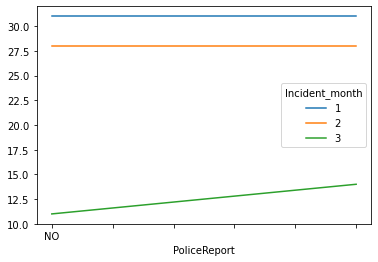

In [130]:
data.pivot_table(index='PoliceReport', columns='Incident_month', values='Incident_day' ,aggfunc=np.max, fill_value = 0).plot()

To verify the time in which major incidents occured 

<AxesSubplot:xlabel='Incident_month'>

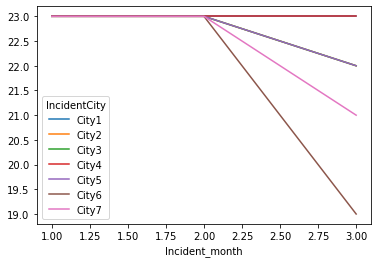

In [131]:
data.pivot_table(index='Incident_month', columns='IncidentCity', values='IncidentTime', aggfunc=np.max, fill_value = 0).plot()

Time slots where major incidents occured 

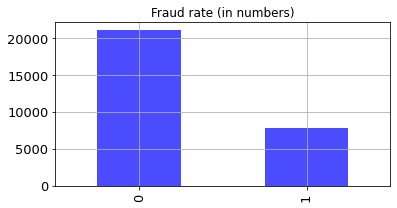

In [134]:
plt.figure()
df_data_comb ['ReportedFraud'].value_counts().plot(kind='bar',
                                  figsize=(6,3),
                                  color="blue",
                                  alpha = 0.7,
                                  fontsize=13)
plt.title('Fraud rate (in numbers)')
plt.grid()
plt.show()

Verfiying how many incidents were police reported as this would help us understand the fraud rate

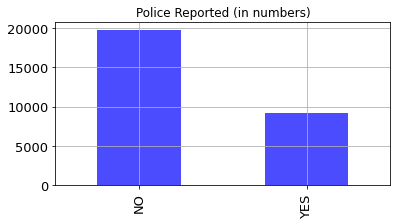

In [135]:
plt.figure()
data_Cat['PoliceReport'].value_counts().plot(kind='bar',
                                  figsize=(6,3),
                                  color="blue",
                                  alpha = 0.7,
                                  fontsize=13)
plt.title('Police Reported (in numbers)')
plt.grid()
plt.show()

Verifying how many incidents resulted in Body Injuries as this is vital while claiming

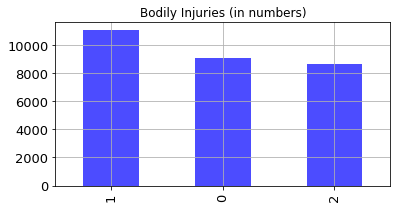

In [136]:
plt.figure()
data['BodilyInjuries'].value_counts().plot(kind='bar',
                                  figsize=(6,3),
                                  color="blue",
                                  alpha = 0.7,
                                  fontsize=13)
plt.title('Bodily Injuries (in numbers)')
plt.grid()
plt.show()

To understand the pattern of incidents/no of incidents occuring per month

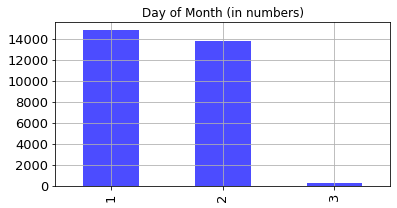

In [137]:
plt.figure()
data['Incident_month'].value_counts().plot(kind='bar',
                                  figsize=(6,3),
                                  color="blue",
                                  alpha = 0.7,
                                  fontsize=13)
plt.title('Day of Month (in numbers)')
plt.grid()
plt.show()

To see which day of the month results in more incidents 

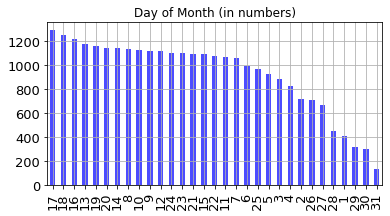

In [138]:
plt.figure()
data_Cat['Incident_day'].value_counts().plot(kind='bar',
                                  figsize=(6,3),
                                  color="blue",
                                  alpha = 0.7,
                                  fontsize=13)
plt.title('Day of Month (in numbers)')
plt.grid()
plt.show()

In [139]:
data.columns

Index(['ReportedFraud', 'TypeOfIncident', 'SeverityOfIncident',
       'AuthoritiesContacted', 'IncidentCity', 'IncidentTime',
       'NumberOfVehicles', 'PropertyDamage', 'BodilyInjuries', 'Witnesses',
       'PoliceReport', 'InsuredAge', 'InsuredEducationLevel',
       'InsuredOccupation', 'CustomerLoyaltyPeriod', 'InsurancePolicyState',
       'Policy_Deductible', 'PolicyAnnualPremium', 'VehicleMake',
       'VehicleModel', 'VehicleYOM', 'Incident_month', 'Incident_day',
       'Policy_month', 'nor_Total_gain_loss', 'nor_Total_amount'],
      dtype='object')

### Time of the day of the max incident occurence 

Text(0, 0.5, 'Frequency')

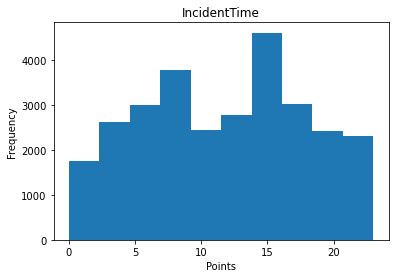

In [140]:

fig, ax = plt.subplots()
# plot histogram
ax.hist(Merged_Train4['IncidentTime'])
# set title and labels
ax.set_title('IncidentTime')
ax.set_xlabel('Points')
ax.set_ylabel('Frequency')

#### SPLITTING OF DATA INTO TRAIN AND TEST

In [141]:
fdf_data_comb.shape

(28836, 68)

In [142]:
fdf_data_test_comb.shape

(8912, 67)

In [143]:
X = fdf_data_comb.drop("ReportedFraud",axis=1)
y = fdf_data_comb["ReportedFraud"]

In [144]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=20, random_state=None)
# X is the feature set and y is the target
for train_index, test_index in skf.split(X,y): 
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
 

TRAIN: [ 1402  1405  1406 ... 28833 28834 28835] TEST: [   0    1    2 ... 1570 1571 1576]
TRAIN: [    0     1     2 ... 28833 28834 28835] TEST: [1402 1405 1406 ... 3001 3002 3007]
TRAIN: [    0     1     2 ... 28833 28834 28835] TEST: [2833 2834 2836 ... 4590 4596 4600]
TRAIN: [    0     1     2 ... 28833 28834 28835] TEST: [4235 4236 4237 ... 5989 5990 5994]
TRAIN: [    0     1     2 ... 28833 28834 28835] TEST: [5668 5669 5671 ... 7280 7282 7290]
TRAIN: [    0     1     2 ... 28833 28834 28835] TEST: [7179 7180 7181 ... 8753 8755 8760]
TRAIN: [    0     1     2 ... 28833 28834 28835] TEST: [ 8613  8614  8615 ... 10220 10224 10230]
TRAIN: [    0     1     2 ... 28833 28834 28835] TEST: [10046 10047 10048 ... 11602 11604 11606]
TRAIN: [    0     1     2 ... 28833 28834 28835] TEST: [11516 11517 11518 ... 13170 13171 13176]
TRAIN: [    0     1     2 ... 28833 28834 28835] TEST: [12893 12895 12897 ... 14559 14563 14566]
TRAIN: [    0     1     2 ... 28833 28834 28835] TEST: [14367 1436

In [145]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [146]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(27395, 67)
(1441, 67)
(27395,)
(1441,)


In [147]:
X_train.drop(['AuthoritiesContacted'],axis=1,inplace=True)
X_test.drop(['AuthoritiesContacted'],axis=1,inplace=True)
fdf_data_test_comb.drop(['AuthoritiesContacted'],axis=1,inplace=True)

## Model Building

#### Random Forest

In [148]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=50,criterion='entropy',max_features=0.65,n_jobs = -1,random_state =12)

In [149]:
X_train.columns

Index(['Incident_day', 'NumberOfVehicles', 'BodilyInjuries', 'Incident_month',
       'Policy_month', 'InsuredAge', 'nor_Total_gain_loss',
       'CustomerLoyaltyPeriod', 'IncidentTime', 'nor_Total_amount',
       'Policy_Deductible', 'PolicyAnnualPremium', 'VehicleYOM',
       'InsuredEducationLevel_College', 'InsuredEducationLevel_High School',
       'InsuredEducationLevel_JD', 'InsuredEducationLevel_MD',
       'InsuredEducationLevel_Masters', 'InsuredEducationLevel_PhD',
       'InsuredOccupation_armed-forces', 'InsuredOccupation_craft-repair',
       'InsuredOccupation_exec-managerial',
       'InsuredOccupation_farming-fishing',
       'InsuredOccupation_handlers-cleaners',
       'InsuredOccupation_machine-op-inspct',
       'InsuredOccupation_other-service', 'InsuredOccupation_priv-house-serv',
       'InsuredOccupation_prof-specialty', 'InsuredOccupation_protective-serv',
       'InsuredOccupation_sales', 'InsuredOccupation_tech-support',
       'InsuredOccupation_transport-m

In [150]:
rfc.fit(X = X_train,y = y_train)

RandomForestClassifier(criterion='entropy', max_features=0.65, n_estimators=50,
                       n_jobs=-1, random_state=12)

In [151]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [152]:
## Predict
train_predictions = rfc.predict(X_train)
test_predictions = rfc.predict(X_test)

print("TRAIN DATA ACCURACY",accuracy_score(y_train,train_predictions))
print("\nTrain data f1-score for class 'N'",f1_score(y_train,train_predictions,pos_label=0))
print("\nTrain data f1-score for class 'Y'",f1_score(y_train,train_predictions,pos_label=1))

### Test data accuracy
print("\n\n--------------------------------------\n\n")
print("TEST DATA ACCURACY",accuracy_score(y_test,test_predictions))
print("\nTest data f1-score for class 'N'",f1_score(y_test,test_predictions,pos_label=0))
print("\nTest data f1-score for class 'Y'",f1_score(y_test,test_predictions,pos_label=1))

TRAIN DATA ACCURACY 0.9995619638620186

Train data f1-score for class 'N' 0.9997000599880024

Train data f1-score for class 'Y' 0.9991882018671358


--------------------------------------


TEST DATA ACCURACY 0.916030534351145

Test data f1-score for class 'N' 0.9437470943747095

Test data f1-score for class 'Y' 0.8344733242134063


In [153]:
test_pred=rfc.predict(fdf_data_test_comb)

In [154]:
pred1 = pd.DataFrame(test_pred, columns=['ReportedFraud']).to_csv('test_predictions_phd_New123.csv')

Randomised search

In [155]:
from sklearn.model_selection import RandomizedSearchCV #hyperparameter tuning
from sklearn.metrics import make_scorer

## n_jobs = -1 uses all cores of processor
## max_features is the maximum number of attributes to select for each tree
rfc_grid = RandomForestClassifier(n_jobs=-1, max_features=0.6, class_weight='balanced_subsample')
 
# Use a grid over parameters of interest
## n_estimators is the number of trees in the forest
## max_depth is how deep each tree can be
## min_sample_leaf is the minimum samples required in each leaf node for the root node to split
## "A node will only be split if in each of it's leaf nodes there should be min_sample_leaf"

param_grid = {"n_estimators" : [10, 25, 50, 75, 100],
           "max_depth" : [10, 12, 14, 16, 18, 20],
           "min_samples_leaf" : [5, 10, 15, 20],
           "class_weight" : ['balanced','balanced_subsample']}
 
rfc_cv_grid = RandomizedSearchCV(estimator = rfc_grid, 
                                 param_distributions = param_grid, 
                                 cv = 3, n_iter=16)

In [156]:
rfc_cv_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    max_features=0.6,
                                                    n_jobs=-1),
                   n_iter=16,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [10, 12, 14, 16, 18, 20],
                                        'min_samples_leaf': [5, 10, 15, 20],
                                        'n_estimators': [10, 25, 50, 75, 100]})

In [157]:
rfc_cv_grid.best_params_
#rfc_cv_grid.best_estimator_

{'n_estimators': 10,
 'min_samples_leaf': 5,
 'max_depth': 18,
 'class_weight': 'balanced'}

In [158]:
## Predict
train_predictions = rfc_cv_grid.predict(X_train)
test_predictions = rfc_cv_grid.predict(X_test)

print("TRAIN DATA ACCURACY",accuracy_score(y_train,train_predictions))
print("\nTrain data f1-score for class 'N'",f1_score(y_train,train_predictions,pos_label=0))
print("\nTrain data f1-score for class 'Y'",f1_score(y_train,train_predictions,pos_label=1))

### Test data accuracy
print("\n\n--------------------------------------\n\n")
print("TEST DATA ACCURACY",accuracy_score(y_test,test_predictions))
print("\nTest data f1-score for class 'N'",f1_score(y_test,test_predictions,pos_label=0))
print("\nTest data f1-score for class 'Y'",f1_score(y_test,test_predictions,pos_label=1))

TRAIN DATA ACCURACY 0.9364847599926994

Train data f1-score for class 'N' 0.9564171926660655

Train data f1-score for class 'Y' 0.882954392573658


--------------------------------------


TEST DATA ACCURACY 0.8910478834142956

Test data f1-score for class 'N' 0.92541567695962

Test data f1-score for class 'Y' 0.797940797940798
